In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.ticker as ticker
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

## Prepare data for analys

In [3]:
data = pd.read_csv(filepath_or_buffer='/home/kharlamov/Документы/Project_vas/output/old/ListProteins.csv')
data = data[data.columns[1:]]

#### Create ListProteins

In [4]:
# Очистка ненужных колонок связанных с неточным секвенированием.
# Удаление freq в столбцах, установка частот в столбцах, вместо количества.
# В колонку protein очистка от ненужной информации.
data['sum'] = data.loc[:, "freq_A":"freq_X"].sum(axis=1)
data.loc[:,"freq_A":"freq_X"] = data.loc[:,"freq_A":"freq_X"].div(data["sum"], axis=0)
data = data[data.columns[:-1]]
data.rename(columns={name : name.split('_')[1] for name in list(data.columns[4:])}, inplace = True)
data['protein'] = map(lambda x: x.split('|')[1], data['protein'])
data = data[['organism', 'protein', 'strain', 'type', 'A', 'N', 'C', 'E', 'H', 
             'L', 'M', 'P', 'T', 'Y', 'R', 'D', 'Q', 'G', 'I', 'K', 'F', 'S', 'W', 'V']]

In [69]:
# Сохранение результатов в output
data.to_csv('/home/kharlamov/Документы/Project_vas/output/ListProteins.csv')

#### Create ListProteinsFreq

In [5]:
# Создание датасета для исследования

data_tmp = data[data.columns[3:]]
data_tmp[data_tmp.columns[0]] = map(lambda x: 0 if x == 'human' else 1, data_tmp[data_tmp.columns[0]])
data_tmp = data_tmp[data_tmp.columns[:-1]]

In [73]:
# Сохранение результатов в output
data_tmp.to_csv('/home/kharlamov/Документы/Project_vas/output/ListProteinsFreq.csv')

#### Create labels and balanced data for analys

In [6]:
# Создание меток числовых и строковых
labels_name = map(lambda x: 'human' if x == 0 else 'bacteria or virus', data_tmp['type'])
labels_numeric = data_tmp['type']
labels_name_3classes = map(lambda x: 0 if x == 'human' else 1 if x == 'virus' else 2, data['type'])

In [7]:
data_human = data_tmp[data_tmp['type'] == 0]
data_bactvirus = data_tmp[data_tmp['type'] == 1]
df_majority_downsampled = sklearn.utils.shuffle(data_human, 
                                 replace=False,     
                                 n_samples=len(data_bactvirus),      
                                 random_state=42)  
df_balance = pd.concat([df_majority_downsampled, data_bactvirus])
df_balance.describe()

type             A             N             C             E  \
count  64400.000000  64400.000000  64400.000000  64400.000000  64400.000000   
mean       0.500000      0.082686      0.036686      0.017687      0.063524   
std        0.500004      0.037321      0.021646      0.018856      0.031077   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.056604      0.022121      0.006349      0.043885   
50%        0.500000      0.078302      0.034043      0.013699      0.061441   
75%        1.000000      0.104790      0.047771      0.023490      0.079349   
max        1.000000      0.447059      0.287234      0.411765      0.500000   

                  H             L             M             P             T  \
count  64400.000000  64400.000000  64400.000000  64400.000000  64400.000000   
mean       0.023579      0.101994      0.026050      0.052664      0.052925   
std        0.015562      0.034428      0.014961      0.031585      0.022108   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.013405      0.080155      0.016393      0.033333      0.040000   
50%        0.022026      0.100000      0.023622      0.047414      0.051370   
75%        0.031353      0.121662      0.032581      0.064748      0.063495   
max        0.437500      0.500000      0.285714      0.473118      0.380952   

                  Y             R             D             Q             G  \
count  64400.000000  64400.000000  64400.000000  64400.000000  64400.000000   
mean       0.027595      0.057586      0.049601      0.042505      0.069318   
std        0.017094      0.028956      0.022547      0.023601      0.030451   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.016187      0.038339      0.035067      0.027209      0.049751   
50%        0.025862      0.054656      0.049587      0.039954      0.067308   
75%        0.036885      0.072762      0.062810      0.054054      0.085753   
max        0.321429      0.466667      0.349391      0.987500      0.750000   

                  I             K             F             S             W  
count  64400.000000  64400.000000  64400.000000  64400.000000  64400.000000  
mean       0.052538      0.053814      0.038349      0.070687      0.013563  
std        0.028592      0.034151      0.021481      0.030934      0.012159  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.033592      0.029046      0.024390      0.050926      0.004950  
50%        0.049147      0.048291      0.035714      0.065789      0.011364  
75%        0.067485      0.072797      0.049223      0.084932      0.019499  
max        0.500000      0.461538      0.466667      0.416603      0.232877

#### Создание тренировочного и тестового dataset'а

In [8]:
data_train, data_test = train_test_split(data_tmp, test_size=0.2, random_state=42)

In [9]:
data_train_x, data_train_y = data_train[data_train.columns[1:]], data_train[data_train.columns[0]]
data_test_x, data_test_y = data_test[data_train.columns[1:]], data_test[data_train.columns[0]]

#### Создание тренировочного и тестового dataset'а на сбалансированных данных

In [10]:
x_train_balance, x_test_balance = train_test_split(df_balance)
x_train_balance, y_train_balance = x_train_balance[x_train_balance.columns[1:]], x_train_balance['type']
x_test_balance, y_test_balance = x_test_balance[x_test_balance.columns[1:]], x_test_balance['type']

### Comparison of logistic regression and random forest

In [11]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_lg = LogisticRegression(C=100, random_state=42)

In [12]:
clf_rf.fit(data_train_x, data_train_y)
clf_lg.fit(data_train_x, data_train_y)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [112]:
print('Result RandomForest:')
print('Accuracy on train = ' + str(clf_rf.score(data_train_x, data_train_y)))
print('Accuracyc on test = ' + str(clf_rf.score(data_test_x, data_test_y)))
print('\nResult LogisticRegression:')
print('Accuracy on train = ' + str(clf_lg.score(data_train_x, data_train_y)))
print('Accuracyc on test = ' + str(clf_lg.score(data_test_x, data_test_y)))

Result RandomForest:
Accuracy on train = 1.0
Accuracyc on test = 0.8995776630689817

Result LogisticRegression:
Accuracy on train = 0.844108917279649
Accuracyc on test = 0.8438761145002346


In [113]:
#predict for randomforest/logistic reg
y_pred_rf = clf_rf.predict(data_test_x)
y_pred_lg = clf_lg.predict(data_test_x)

In [117]:
print('Result RandomForest for metrics:')
print('F1 Score = ' + str(f1_score(y_pred_rf, data_test_y)))
print('ROC AUC = ' + str(roc_auc_score(y_pred_rf, data_test_y)))
print('\nResult LogisticRegression:')
print('F1 Score = ' + str(f1_score(y_pred_lg, data_test_y)))
print('ROC AUC = ' + str(roc_auc_score(y_pred_lg, data_test_y)))

Result RandomForest for metrics:
F1 Score = 0.8175618073316282
ROC AUC = 0.9008393190677841

Result LogisticRegression:
F1 Score = 0.724060711619806
ROC AUC = 0.8216974112299382


In [13]:
tmp_value_rf = cross_val_score(clf_rf, data_tmp[data_tmp.columns[1:]], data_tmp['type'], cv=8)
tmp_value_lg = cross_val_score(clf_lg, data_tmp[data_tmp.columns[1:]], data_tmp['type'], cv=8)

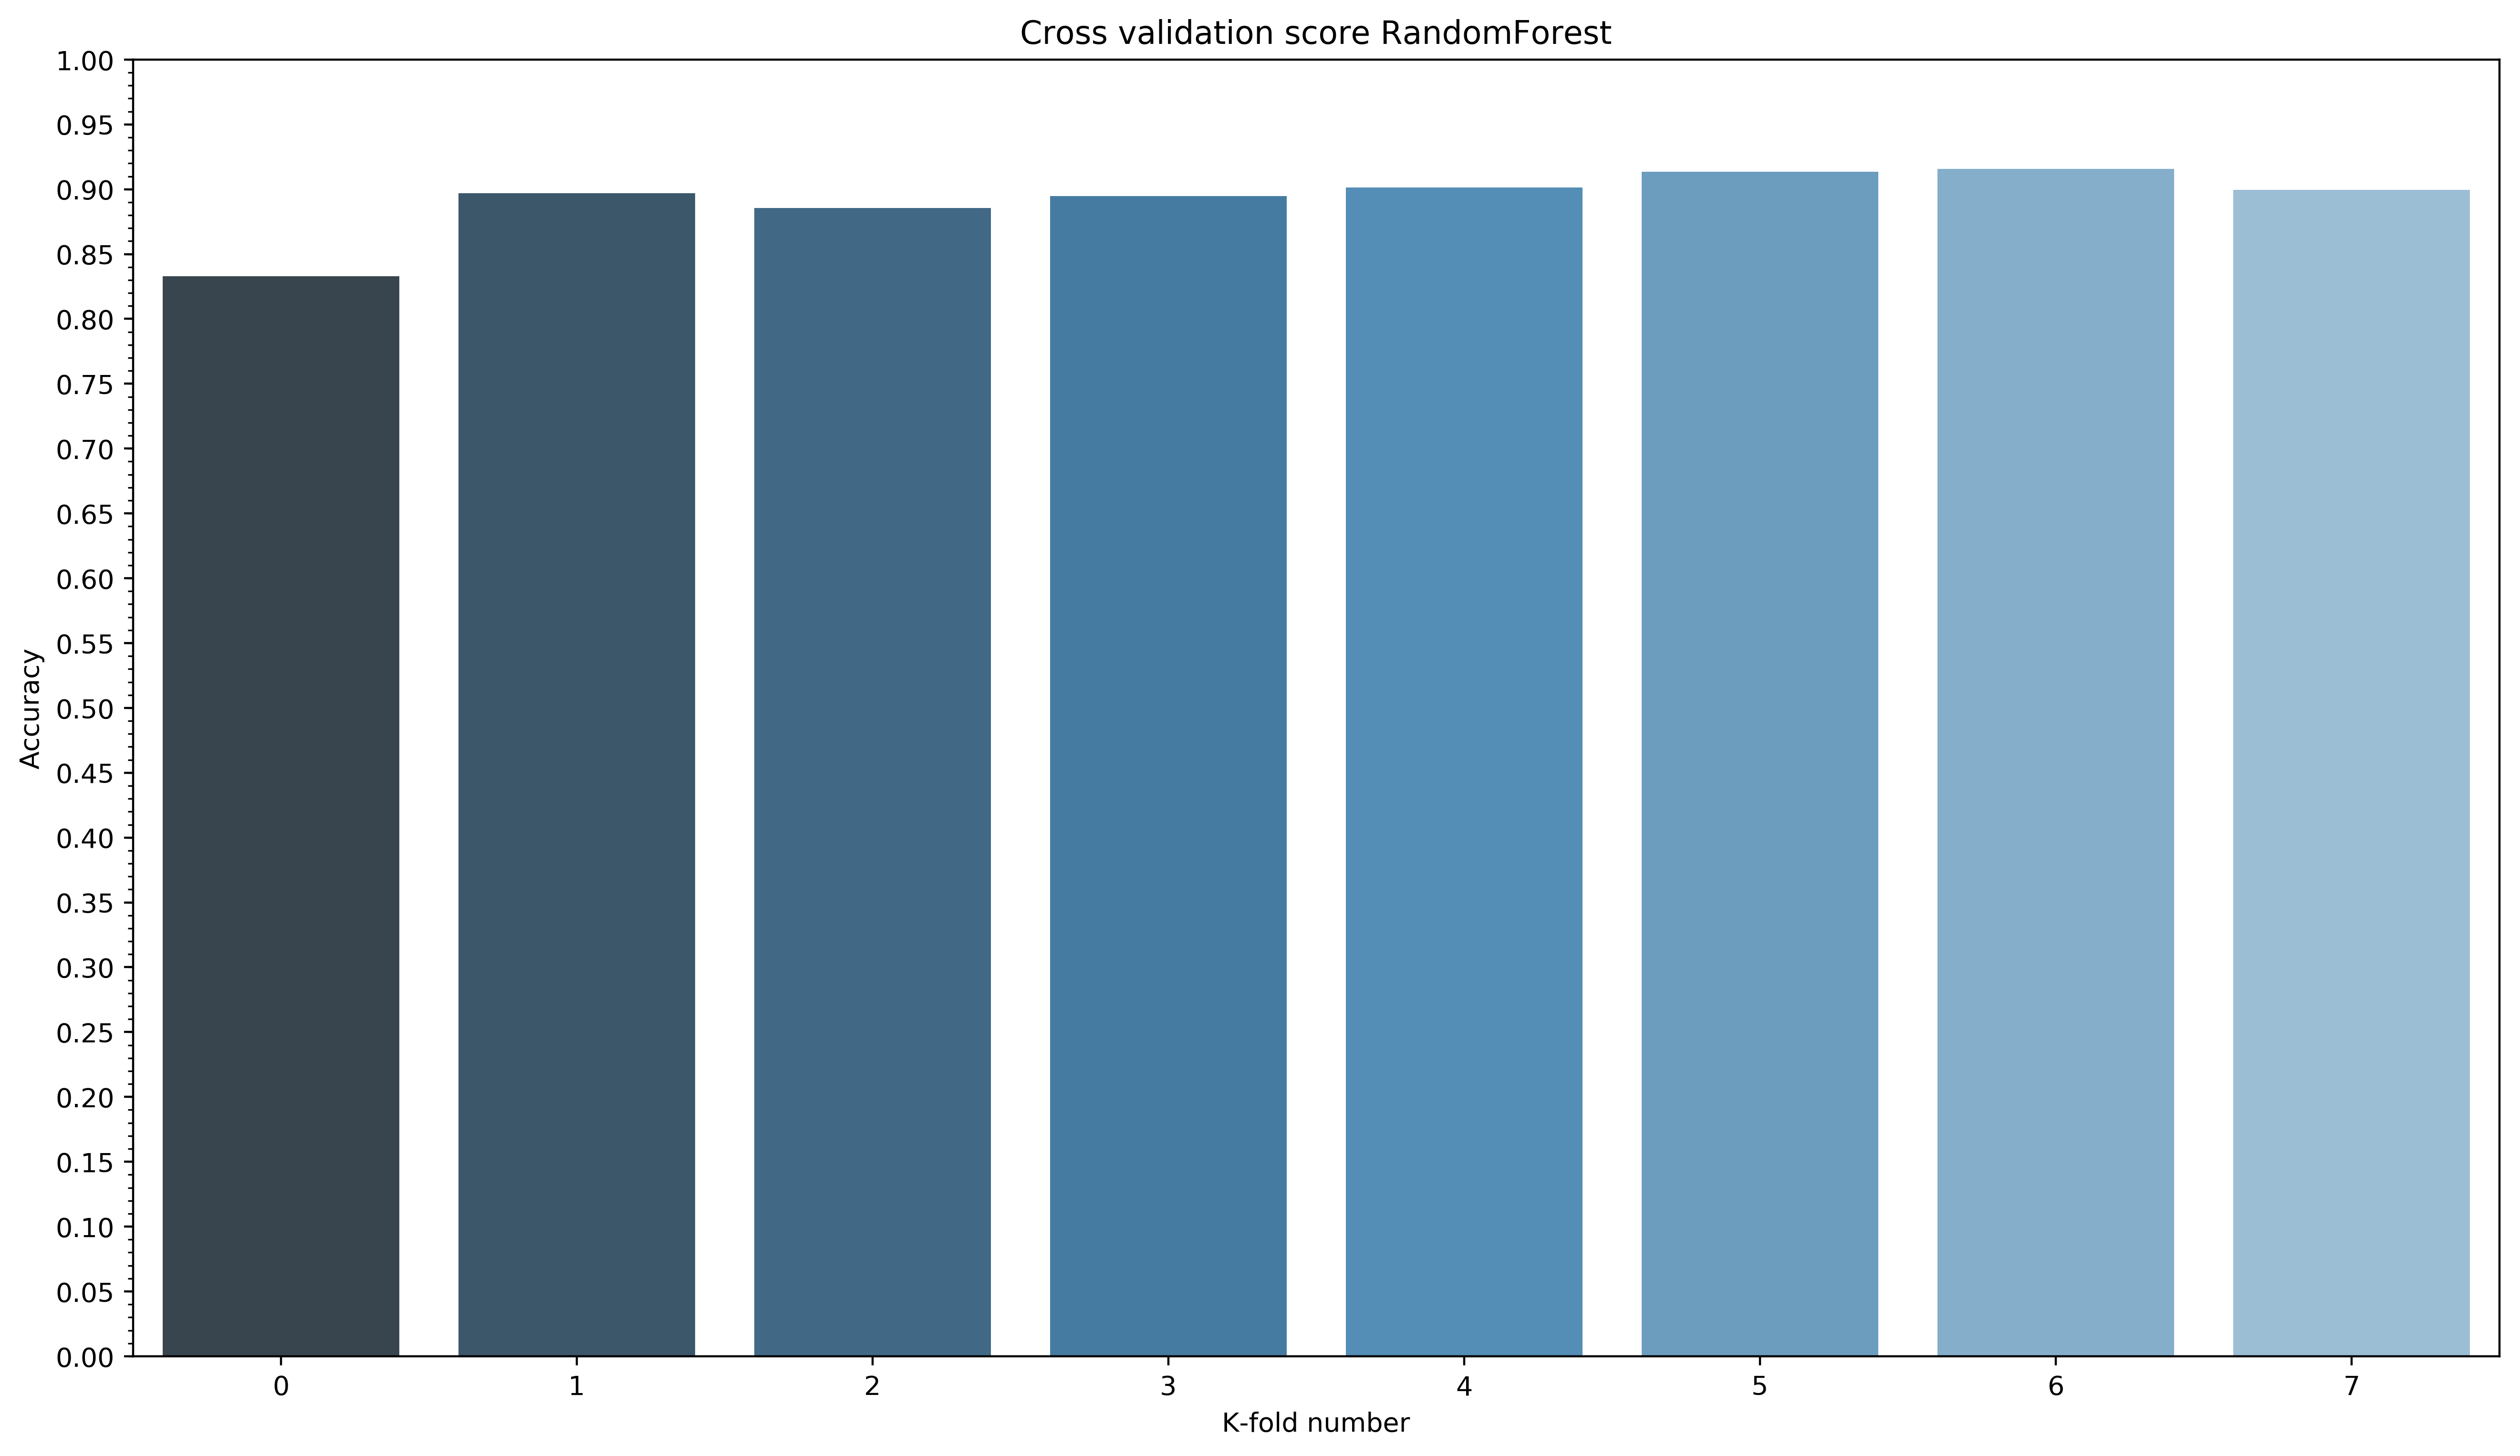

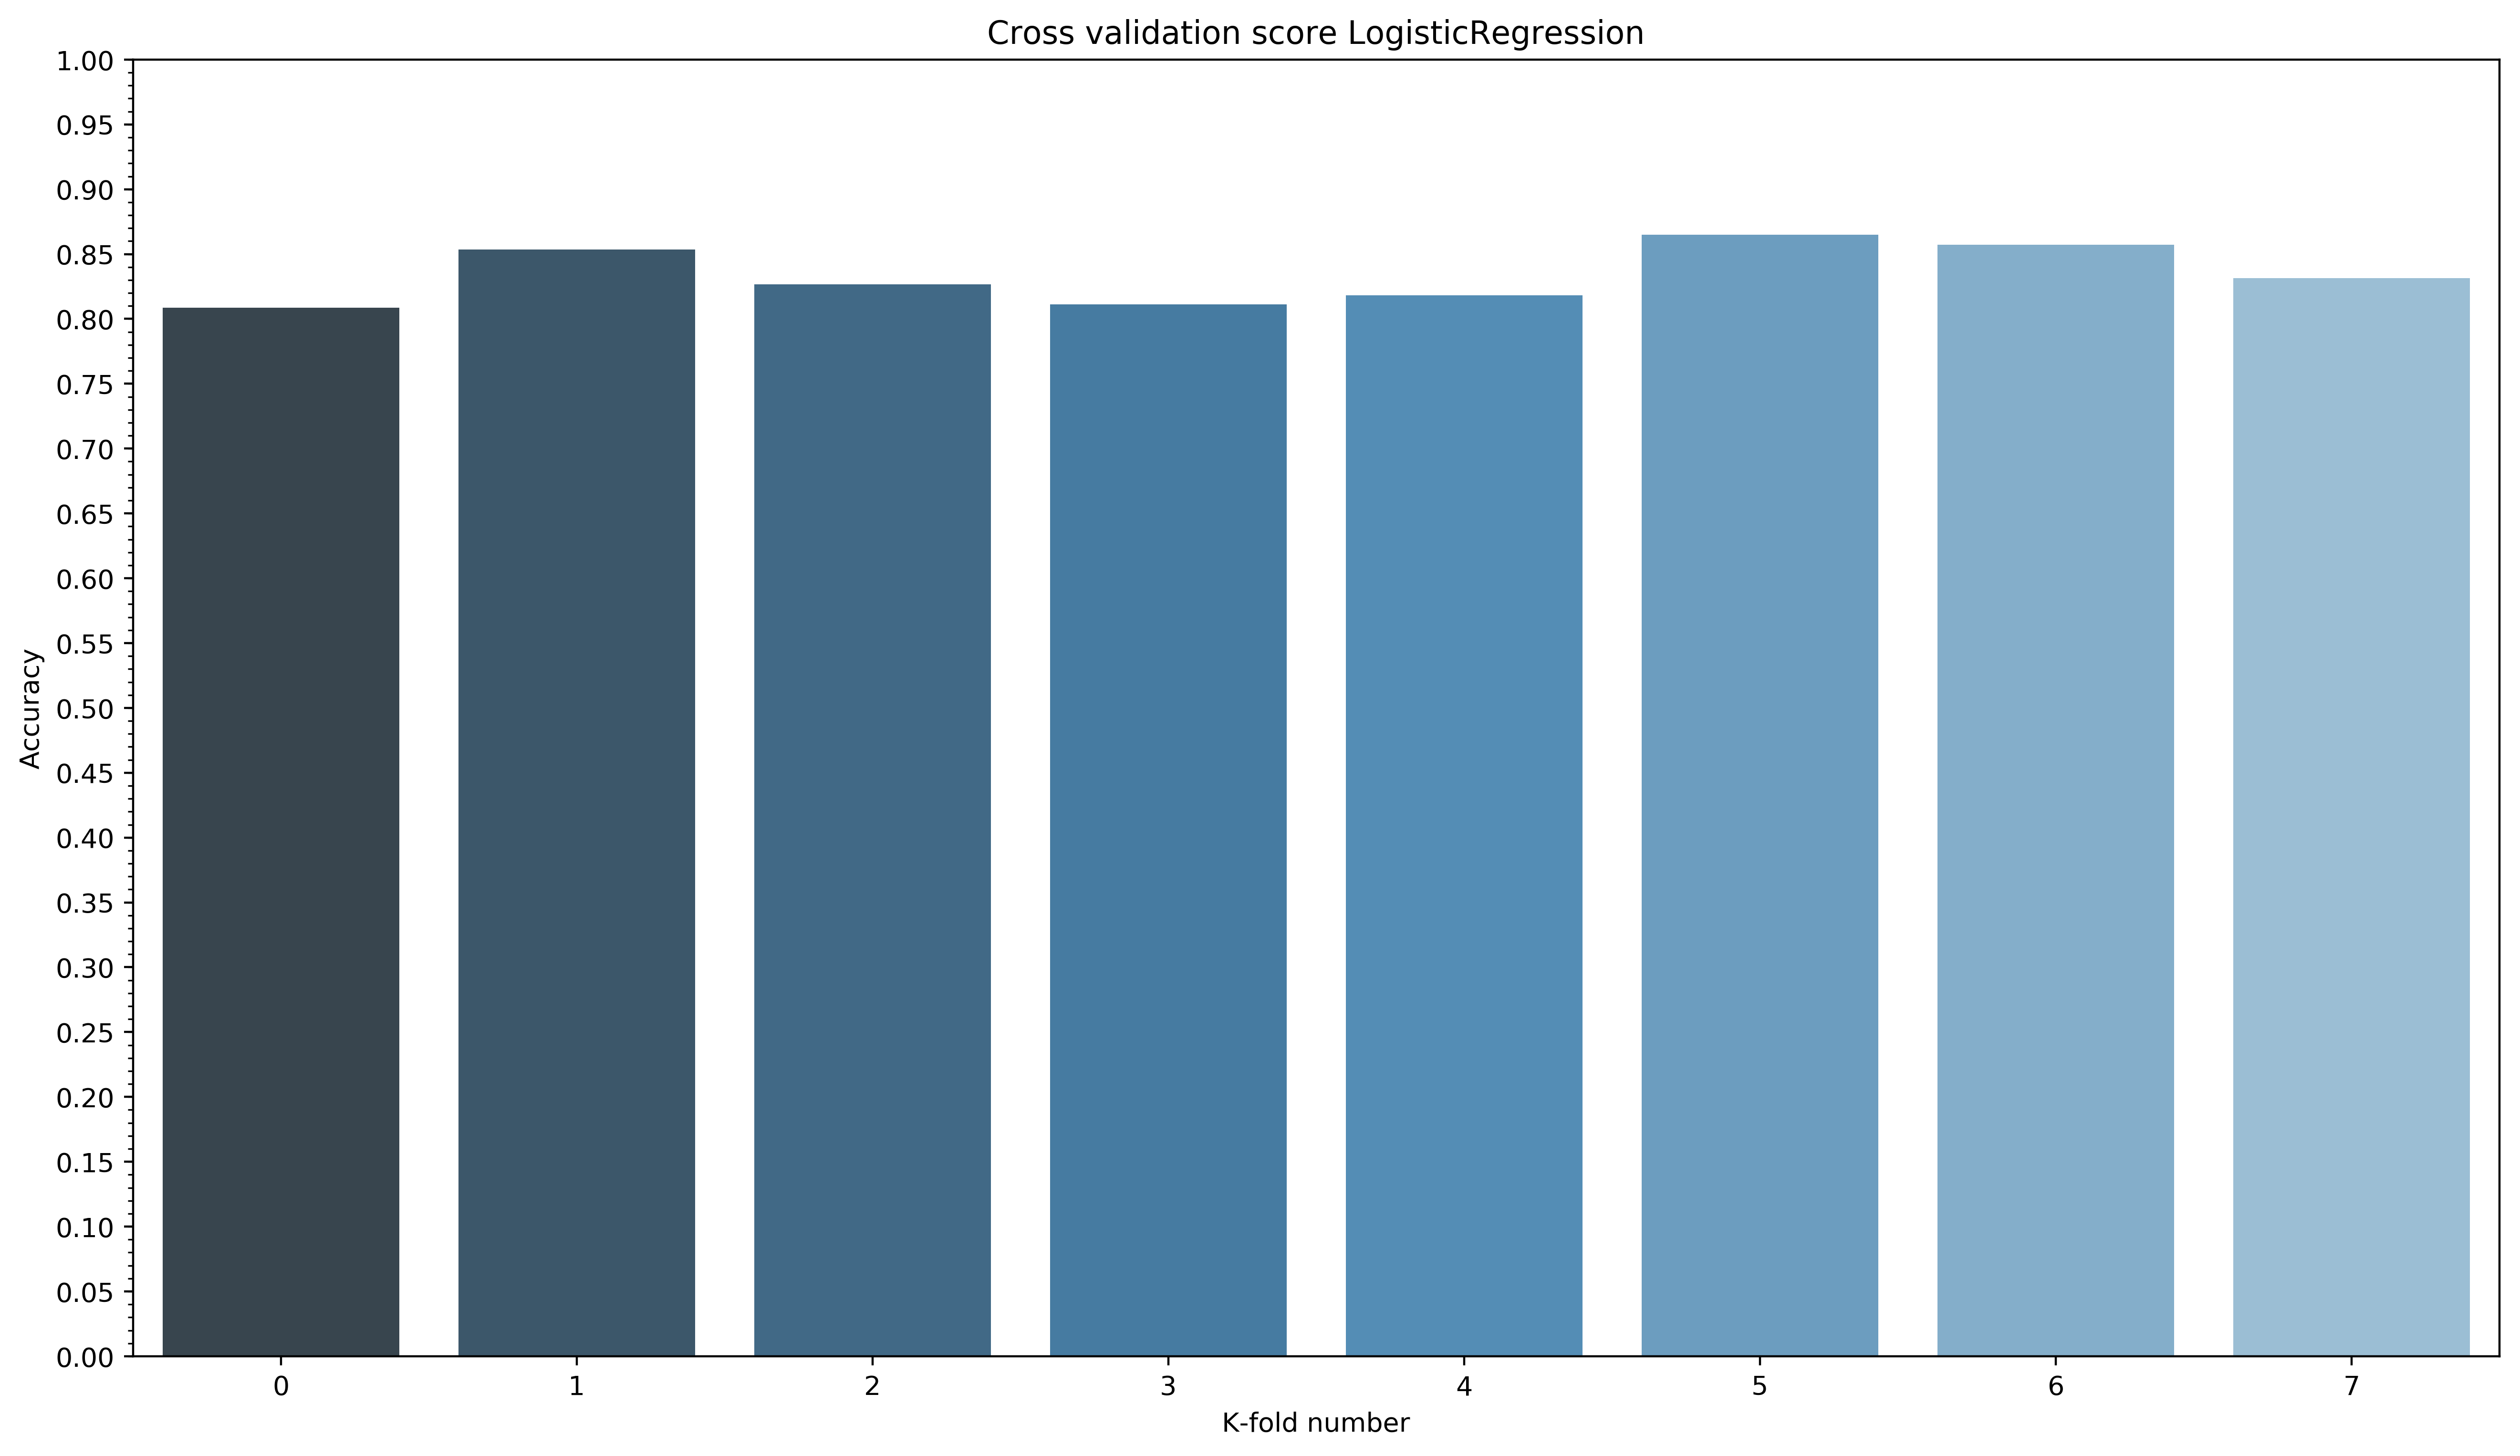

In [24]:
fig, ax = plt.subplots(figsize=(16,9), dpi = 400)
ax.set(xlabel="K-fold number", ylabel="Accuracy", title = 'Cross validation score RandomForest', xlim = [0, 10], ylim = [0, 1])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
sns.barplot(x = [i for i in range(len(tmp_value_rf))], y = tmp_value_rf, ax = ax, palette="Blues_d")
fig, ax = plt.subplots(figsize=(16,9), dpi = 400)
ax.set(xlabel="K-fold number", ylabel="Accuracy", title = 'Cross validation score LogisticRegression', xlim = [0, 10], ylim = [0, 1])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
sns.barplot(x = [i for i in range(len(tmp_value_lg))], y = tmp_value_lg, ax = ax, palette="Blues_d")

### Осмотр данных

Text(0.5,0,'PCA_2')

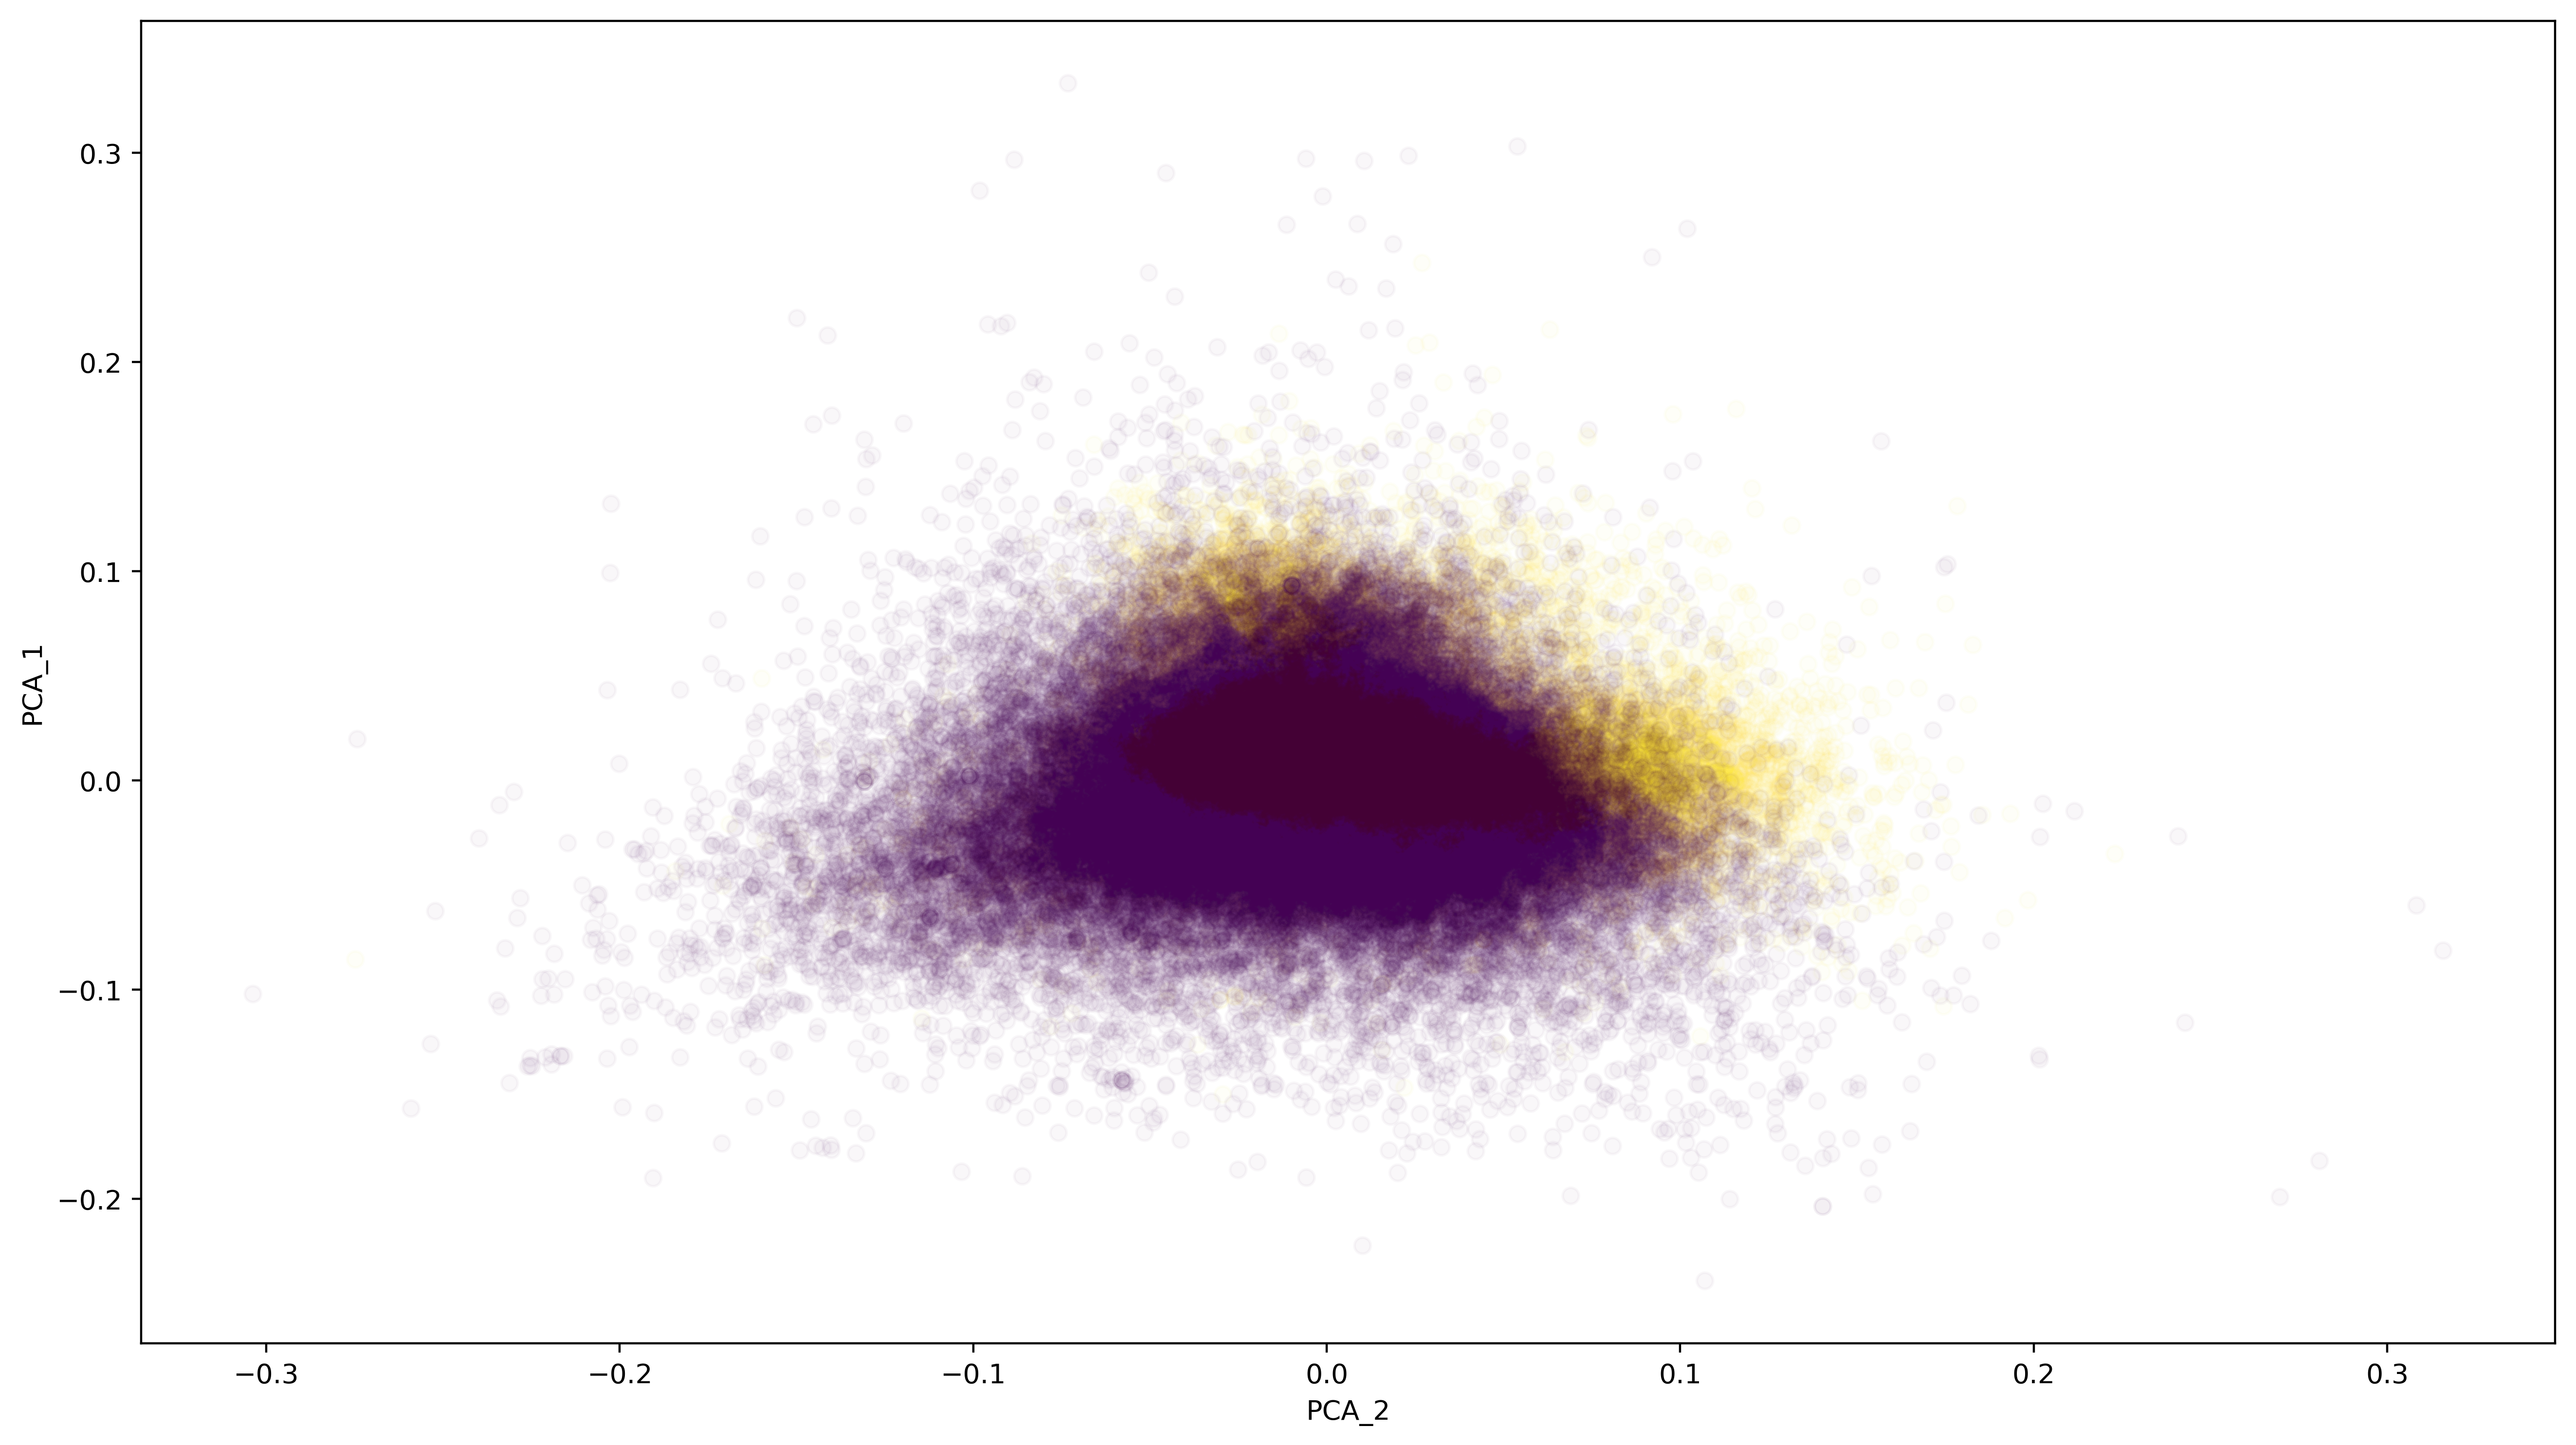

In [16]:
pca = PCA(n_components=2)
data_tmp_1, data_tmp_2 = train_test_split(data_tmp[data_tmp.columns[1:]])
data_tmp_pca_2 = pd.DataFrame(pca.fit_transform(data_tmp[data_tmp_1.columns[1:]]))
fig, ax = plt.subplots(figsize=(16,9), dpi = 400)
ax.scatter(data_tmp_pca_2[0], data_tmp_pca_2[1], c = labels_numeric, alpha=0.03)
ax.set_ylabel("PCA_1")
ax.set_xlabel("PCA_2")

### Важность аминокислот в класификации RandomForest

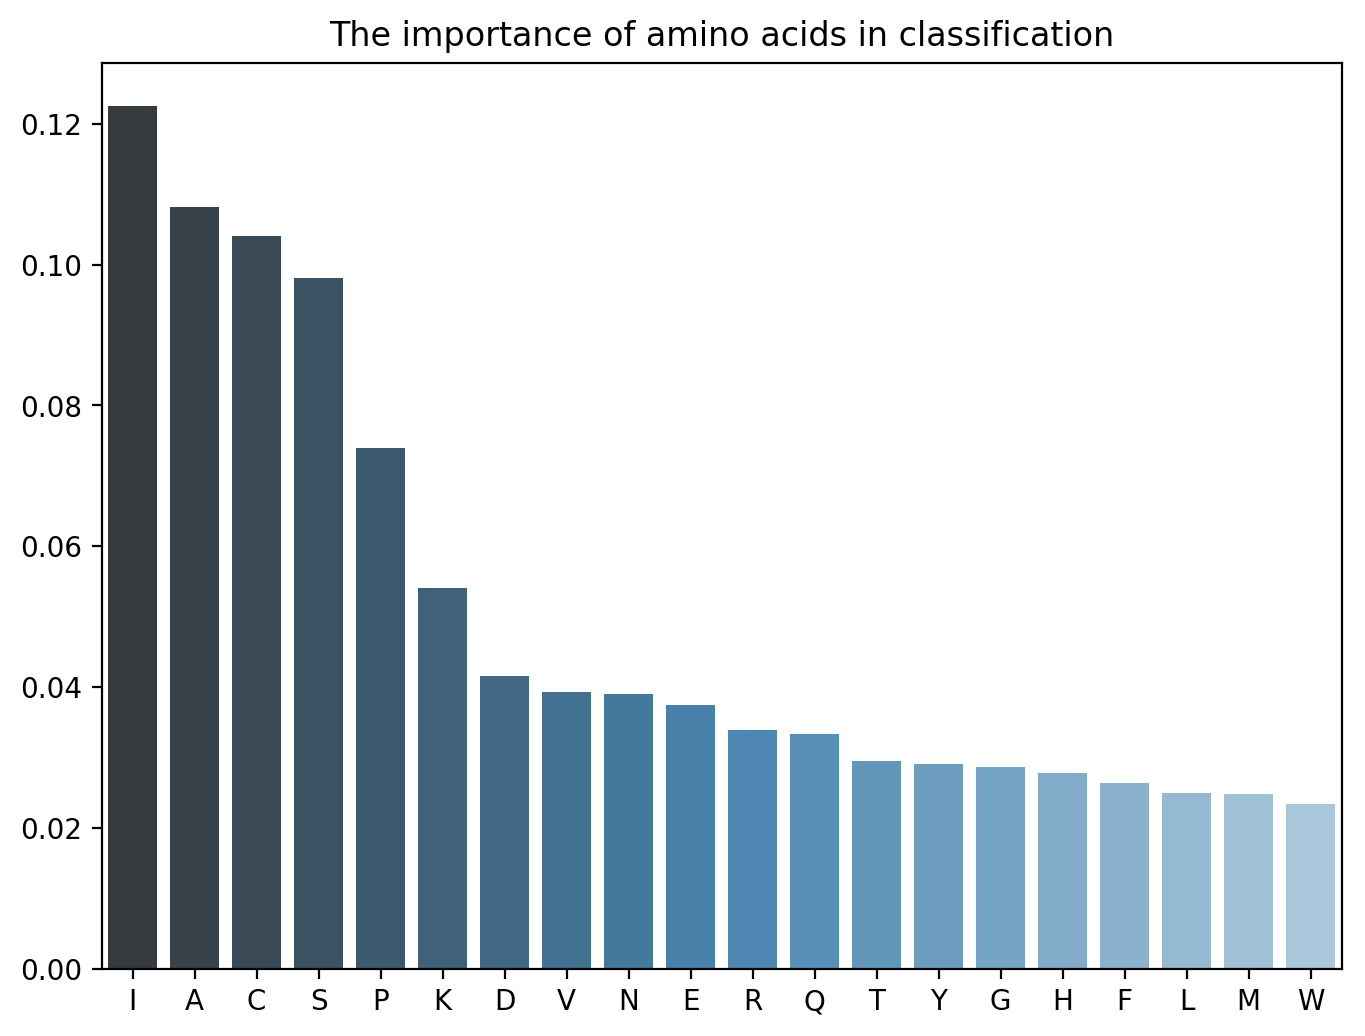

In [132]:
aminoacid = list('ANCEHLMPTYRDQGIKFSWV')
aminoacid_freq = rfc.feature_importances_
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
B = zip(aminoacid, aminoacid_freq)
B.sort(key = lambda x: x[1], reverse=True)
aminoacid = map(lambda x: x[0], B)
aminoacid_freq = map(lambda x: x[1], B)

plt.title('The importance of amino acids in classification')
sns.barplot(aminoacid, aminoacid_freq, palette="Blues_d")

## PCA explained variance, 2d PCA, analyse PCA, EDA
### 1. 2d PCA

In [34]:
pca = PCA(n_components=2)
data_pca = df_balance
labels = data_pca['type']
labels_name = map(lambda x: 'human protein' if x == 0 else 'bacterium or virus protein', labels)
data_pca = pd.DataFrame(pca.fit_transform(data_pca[data_pca.columns[1:]]))
data_pca.columns = 'PCA_1', 'PCA_2'

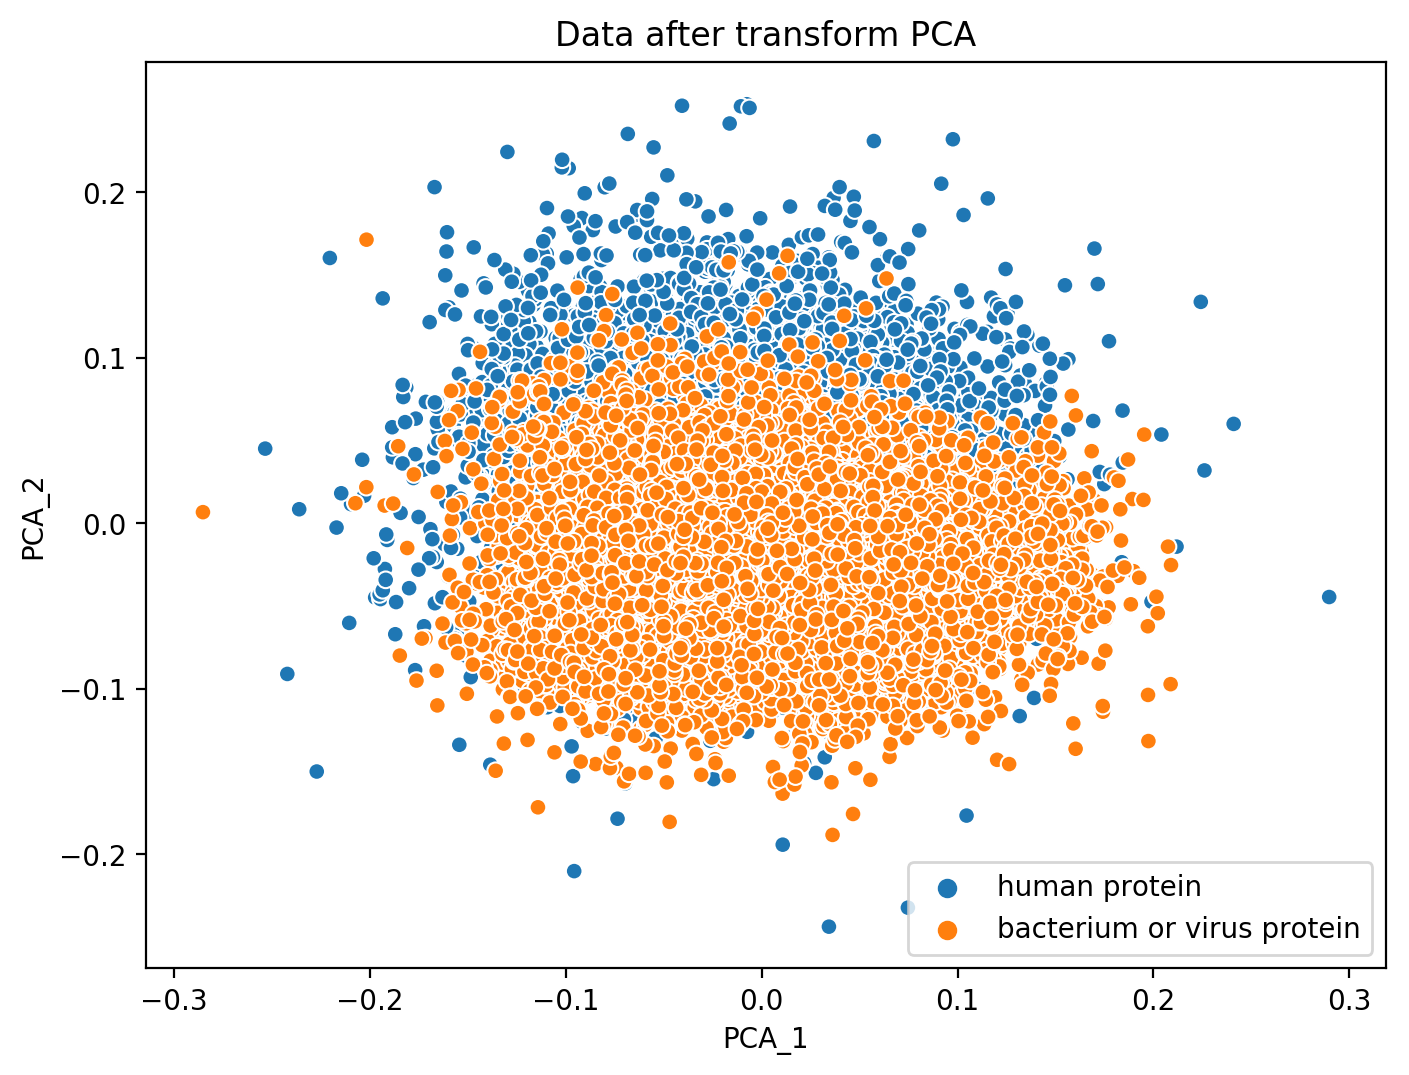

In [42]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
ax.set(xlabel="PCA_1", ylabel="PCA_2", title = 'Data after transform PCA')
sns.scatterplot(data_pca['PCA_1'], data_pca['PCA_2'], hue = labels_name, ax = ax)

## 2. PCA explained variance

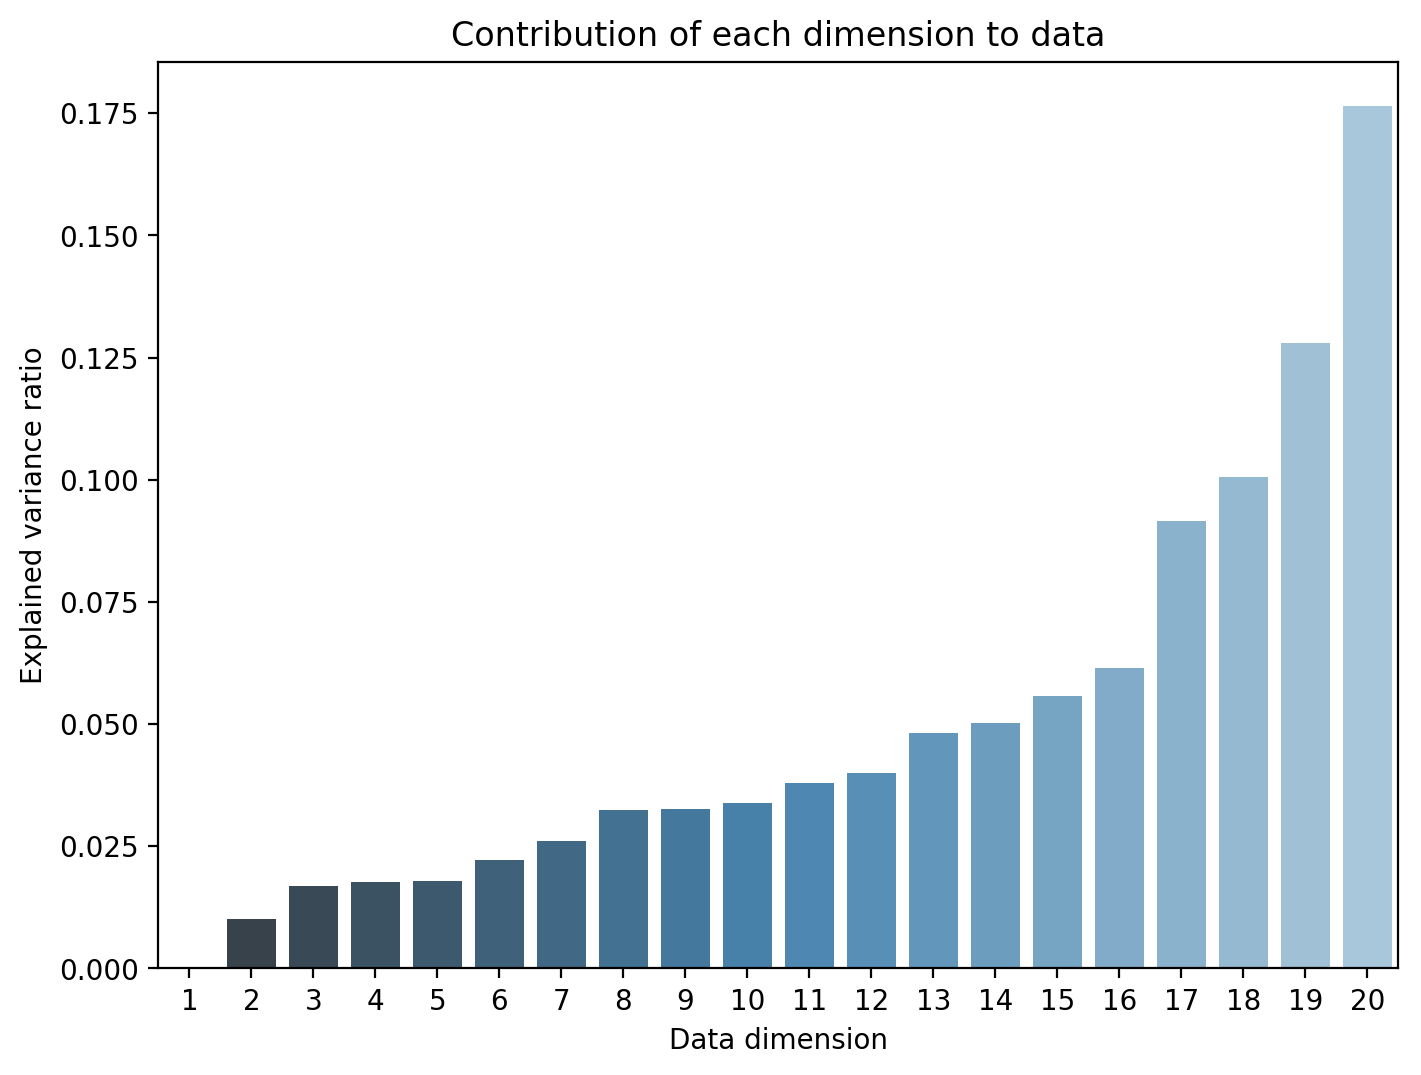

In [45]:
pca = PCA()
pca = pca.fit(data_tmp[data_tmp.columns[1:]])
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
ax.set_ylabel("Explained variance ratio")
ax.set_xlabel("Data dimension")
ax.set_title('Contribution of each dimension to data')
sns.barplot(x = [21-i for i in range(1, 21)], y = pca.explained_variance_ratio_, ax = ax, palette="Blues_d")

## Classifier (cross validation, ROC AUC on balanced data, confusion matrix)
### 1. cross validation

In [26]:
clf = RandomForestClassifier(n_estimators=100, max_features=5)

In [115]:
score_cross_val = cross_val_score(clf, data_tmp[data_tmp.columns[1:]],data_tmp['type'], cv = 8, n_jobs=1)

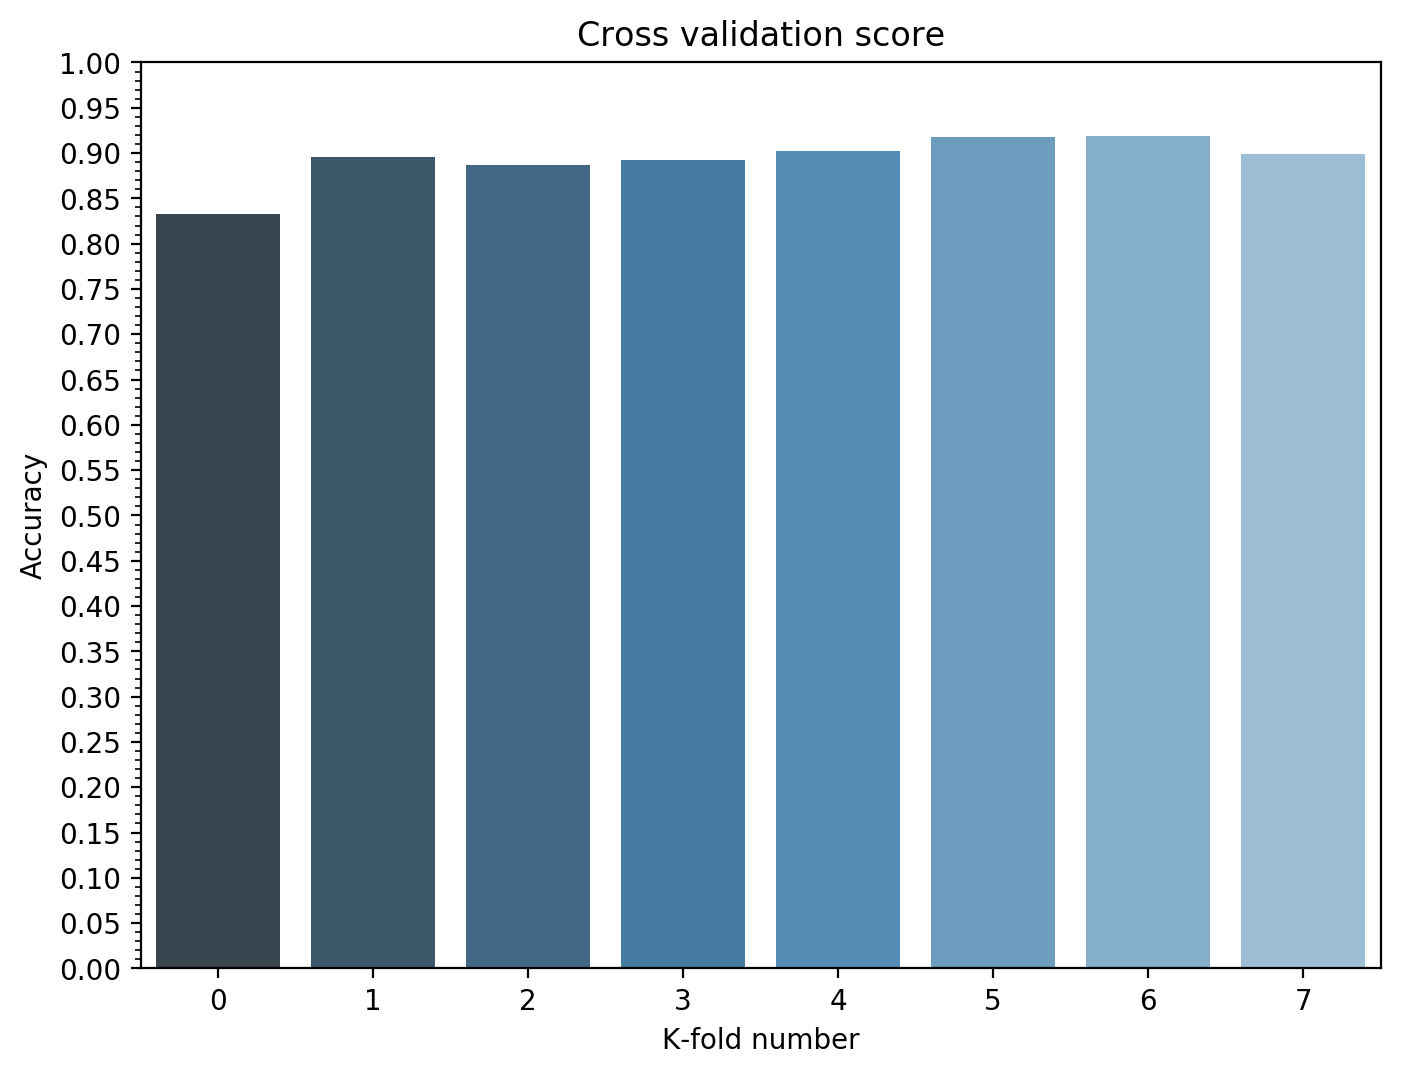

In [116]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
ax.set(xlabel="K-fold number", ylabel="Accuracy", title = 'Cross validation score', xlim = [0, 10], ylim = [0, 1])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
sns.barplot(x = [i for i in range(len(score_cross_val))], y = score_cross_val, ax = ax, palette="Blues_d")

### 2. ROC AUC on balanced data

In [27]:
x_train_balance, x_test_balance = train_test_split(df_balance)
x_train_balance, y_train_balance = x_train_balance[x_train_balance.columns[1:]], x_train_balance['type']
x_test_balance, y_test_balance = x_test_balance[x_test_balance.columns[1:]], x_test_balance['type']

In [28]:
clf.fit(x_train_balance, y_train_balance)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

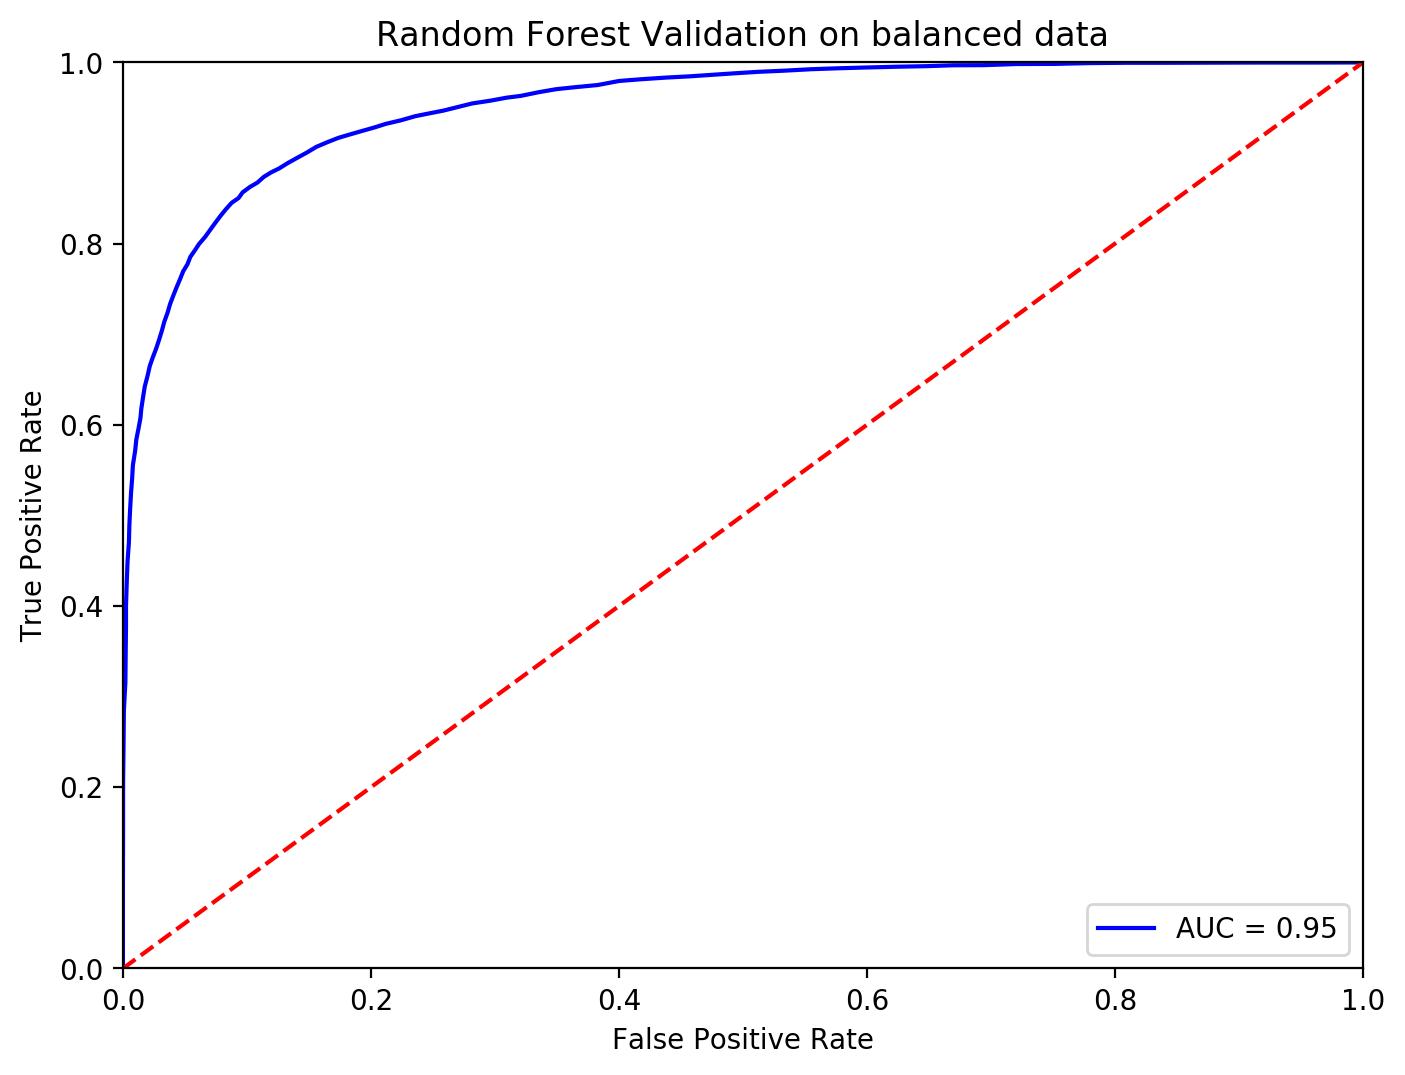

In [59]:
probs = clf.predict_proba(x_test_balance)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_balance, preds)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
plt.title('Random Forest Validation on balanced data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 3. Confusion matrix

[Text(141.444,0.5,'True label'), Text(0.5,91.4444,'Predicted label')]

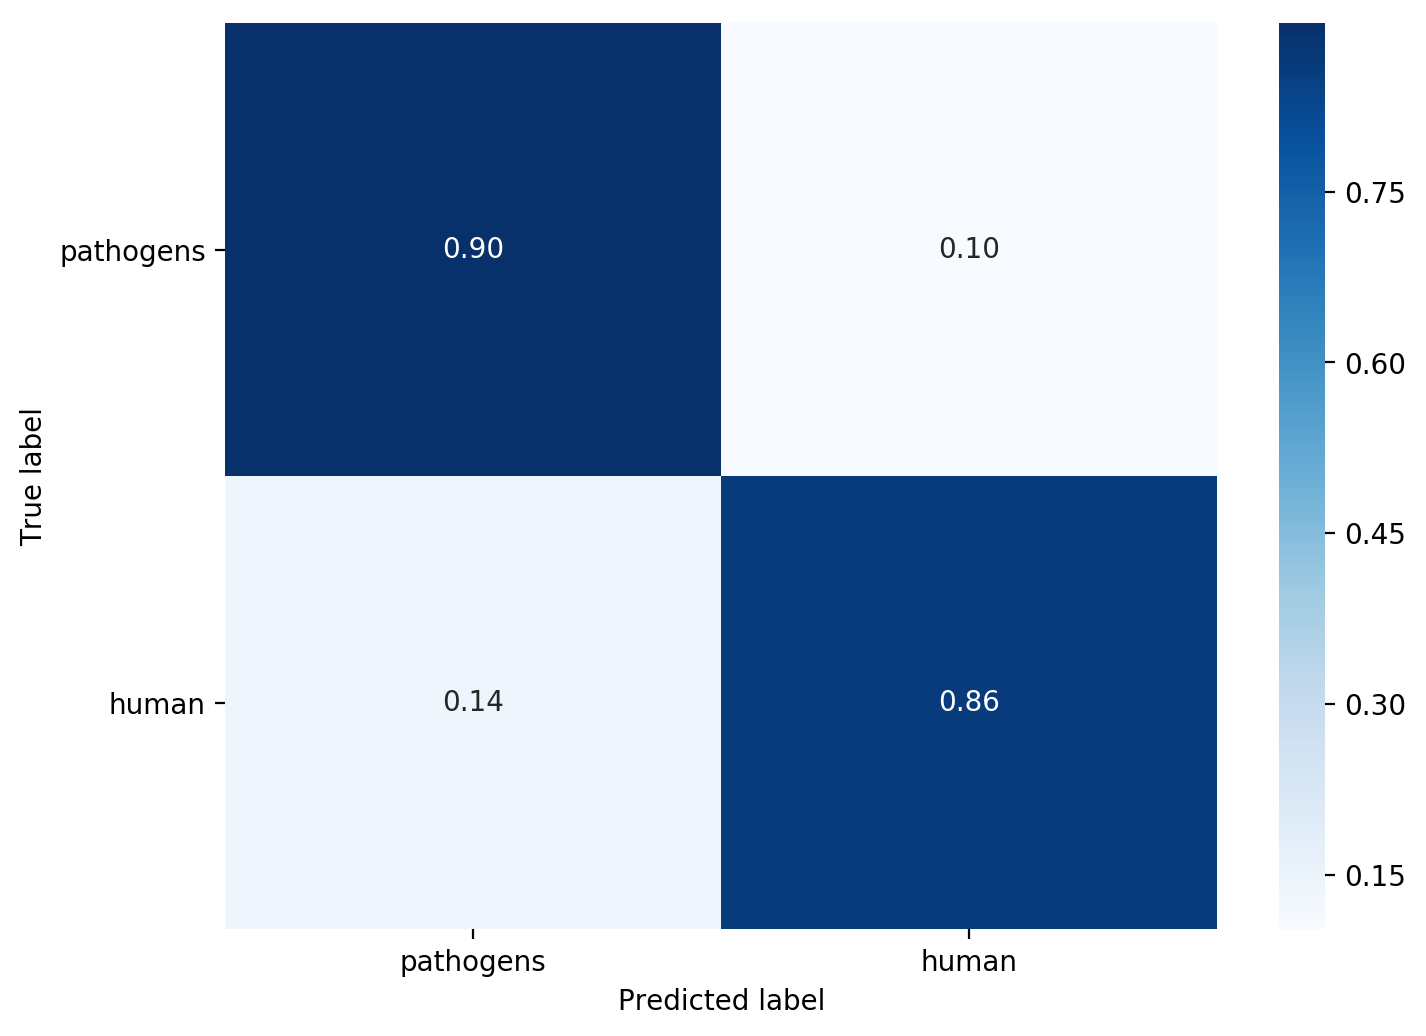

In [87]:
y_true = map(float, y_test_balance)
y_pred = map(float, clf.predict(x_test_balance))
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
g = sns.heatmap(
        cm, 
        cmap=plt.cm.Blues, 
        annot=True,
        xticklabels=["pathogens", "human"]
    , ax = ax, 
    fmt=".2f")
g.set_yticklabels(["pathogens", "human"], rotation=0)
g.set(ylabel='True label', xlabel='Predicted label')

## EDA

In [99]:
mean_human = []
mean_others = []
for column in data_tmp.columns[1:]:
    mean_human.append(data_tmp[data_tmp['type'] == 1][column].mean())
for column in data_tmp.columns[1:]:
    mean_others.append(data_tmp[data_tmp['type'] == 0][column].mean())
A = {column : mean_human[index] for index, column in enumerate(data_tmp.columns[1:])}
B = {column : mean_others[index] for index, column in enumerate(data_tmp.columns[1:])}
A = pd.DataFrame(A, index=[0])
B = pd.DataFrame(B, index=[0])
#C = pd.concat([A,B])
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True, dpi = 400)
#ax1.set_ylabel
#sns.barplot(x = [C.columns[i] for i in range(20)], y = C[C.columns[:-1]].iloc(0)[0], ax = ax1, palette="Blues_d")
#sns.barplot(x = [C.columns[i] for i in range(20)], y = C[C.columns[:-1]].iloc(0)[1], ax = ax2, palette="Blues_d")

In [174]:
mean_human = []
mean_human_std = []
mean_virus = []
mean_virus_std = []
mean_bacterium = []
mean_bacterium_std = []
data_columns = []
for column in data_tmp.columns[1:]:
    if abs(data_tmp[data_tmp['type'] == 0][column].mean() - data_tmp[data_tmp['type'] == 1][column].mean()) > 0.01 or abs(data_tmp[data_tmp['type'] == 0][column].mean() - data_tmp[data_tmp['type'] == 2][column].mean()) > 0.01:
        mean_human.append(data_tmp[data_tmp['type'] == 0][column].mean())
        mean_human_std.append(data_tmp[data_tmp['type'] == 0][column].std())
        mean_virus.append(data_tmp[data_tmp['type'] == 1][column].mean())
        mean_virus_std.append(data_tmp[data_tmp['type'] == 1][column].std())
        mean_bacterium.append(data_tmp[data_tmp['type'] == 2][column].mean())
        mean_bacterium_std.append(data_tmp[data_tmp['type'] == 2][column].std())
        data_columns.append(column)
#C = pd.concat([A,B])
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True, dpi = 400)
#ax1.set_ylabel
#sns.barplot(x = [C.columns[i] for i in range(20)], y = C[C.columns[:-1]].iloc(0)[0], ax = ax1, palette="Blues_d")
#sns.barplot(x = [C.columns[i] for i in range(20)], y = C[C.columns[:-1]].iloc(0)[1], ax = ax2, palette="Blues_d")

In [187]:
data_map = sorted(zip(mean_human, mean_human_std, mean_bacterium_std, mean_bacterium, mean_virus_std, mean_virus, data_columns), reverse=True)
mean_human_std = map(lambda x: x[1], data_map)
mean_human = map(lambda x: x[0], data_map)
mean_bacterium_std = map(lambda x: x[2], data_map)
mean_bacterium = map(lambda x: x[3], data_map)
mean_virus_std = map(lambda x: x[4], data_map)
mean_virus = map(lambda x: x[5], data_map)
data_columns = map(lambda x: x[6], data_map)

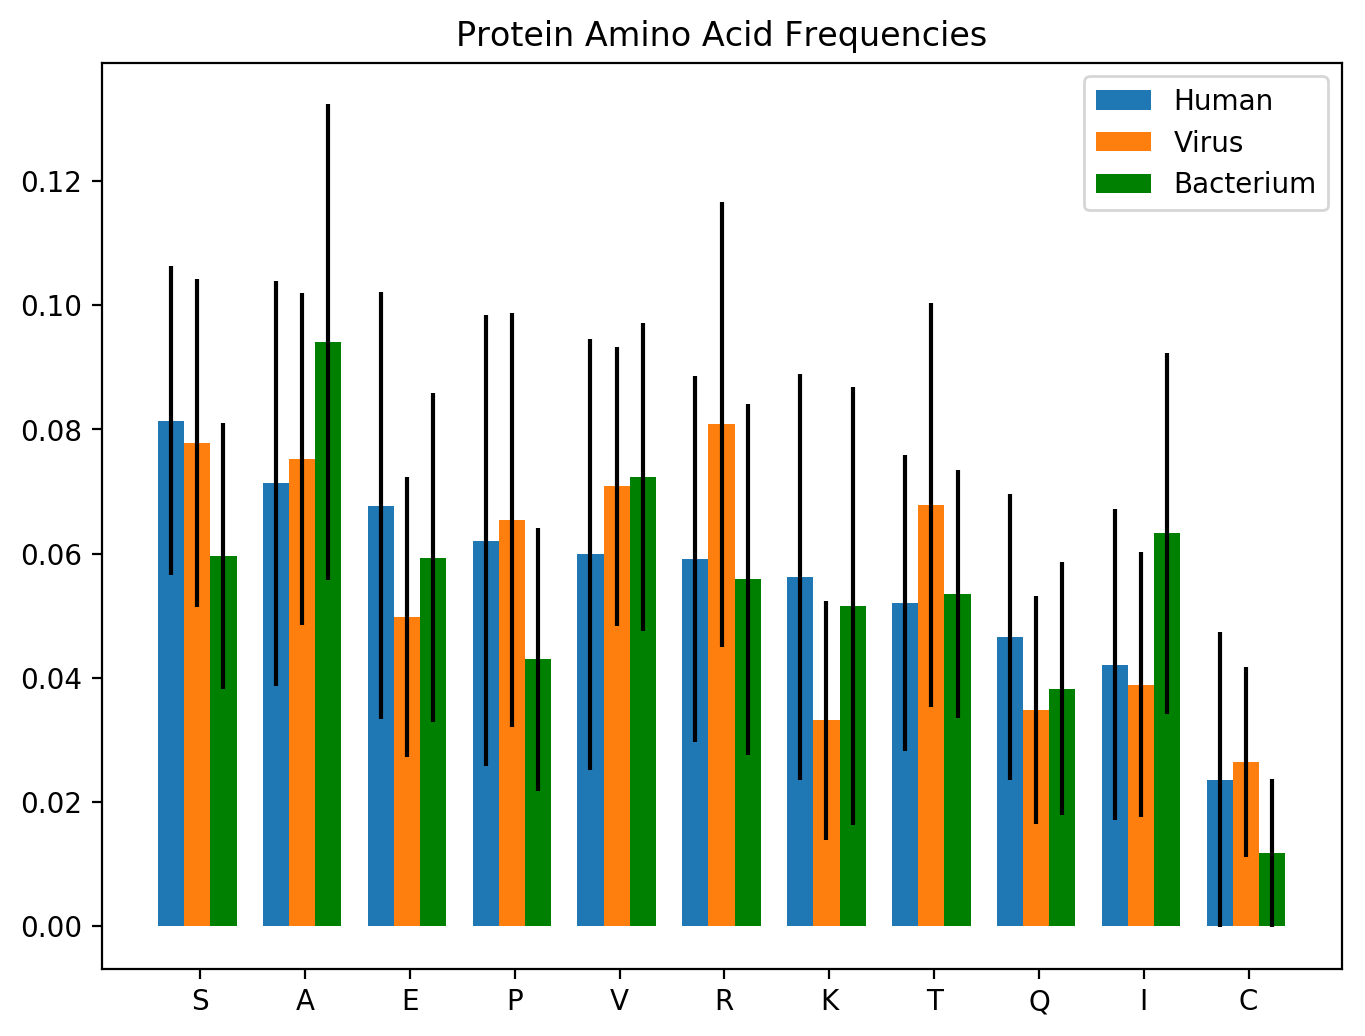

In [188]:
N = len(mean_human)

fig, ax = plt.subplots(figsize=(8,6), dpi = 200)

ind = np.arange(N)    # the x locations for the groups
width = 0.25     # the width of the bars

p1 = ax.bar(ind, mean_human, width, yerr = mean_human_std)

p2 = ax.bar(ind + width, mean_virus, width, yerr = mean_virus_std)

p3 = ax.bar(ind + 2*width, mean_bacterium, width, color = "green", yerr = mean_bacterium_std)

ax.set_title('Protein Amino Acid Frequencies')
ax.set_xticks((3*ind + 2*width)/ 3 + 0.11)
ax.set_xticklabels(data_columns)

ax.legend((p1[0], p2[0], p3[0]), ('Human', 'Virus', 'Bacterium'))
ax.autoscale_view()

plt.show()

## Something else